## 1) Importing packages

In [2]:
import pathlib  

import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import random
import tensorflow as tf

from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

from PIL import Image

## 2) Create functions

### pandas dataframe of images

In [3]:
def build_img_database(path, target):
    
    """ build a pandas dataframe with target class and access path to images
    
    Parameters
    --------
    path: path pattern to read csv file containing images information.
    target (str): name of the target column.
    
    Returns
    -----
    A pandas dataframe, including target class and path to image.
    """
    
    _df = pd.read_csv(path, sep="\t", names=["all"],  dtype = {"all" : str}) 
    
    _df["images_id"] = _df['all'].apply(lambda x: x.split(' ')[0]) # create id 
    
    _df[target] = _df['all'].apply(lambda x: ' ' .join(x.split(' ')[1:])) #create target variable 
    
    # path column is the access path to image
    _df['path'] = _df['images_id'].apply(lambda x: pathlib.Path('images') / (x + '.jpg'))
    
    return _df.drop("all", axis=1)

### Visualize data

In [4]:
def show_image(df,row,target):
    
    """ Show an image from an image database, with the associated class.
    Parameters
    ---------
    df (pd.Dataframe) ; images definition dataframe
    row (int) : row index in df of image to be displayed
    target (str) : name of the target column
    
    Returns
    ------
    None
    """
    plt.imshow(plt.imread(df.iloc[row,]["path"]))
    plt.title(df.iloc[row,][target])
    return 

### resize images

In [5]:
def load_resize_image(path, height, width):
    """ resizing an image into a specific height and width.
    
    Parameters
    ---------
    path ; access path to image dataset.
    height (int) : new height of images. 
    width (int) : new width of images. 
    
    Returns
    ------
    images resized
    """
    return np.array(Image.open(path).resize((width, height)))

### Build train-test set

In [6]:
def build_X_and_y(df: pd.DataFrame,target: str, images: str):
    """ build x tensor and y tensor for model fitting.
    
    Parameters
    -----------
    
    df(pd.DataFrame): dataframe containing image and target
    target (str) : name of target column
    images (str) : name of images column
    
    Returns
    --------
     x (np.array) : tensor of x values
     y (np.array)
    """
    x = np.array(df[images].to_list())
    y = tf.keras.utils.to_categorical(df[target].astype('category').cat.codes) #One Hot Encoder
    return x,y

### Build classification model

In [7]:
def build_classiciation_model(df:pd.DataFrame, target:str, images:str):
    """ 
    build a TF model using information from target abd images columns in dataframe
    
    Parameters 
    -----------
    df (pd.DataFrame): datafrme with target and images columns
    target (str):column name for target variable
    Images (str): column name for images
        
    Returns 
    ---------
    TF model built and compiled
    """
    nb_classes = df[target].nunique() #compute number of classes of output layer
    sizes = df[images].iloc[0].shape #compute image size for input layer
    
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=sizes))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(nb_classes, activation='softmax'))

    #Compiling the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

### Classify images

In [8]:
def classify_images(images, model, classes_names= None):
    """ Classify images through a TF model.
    
    Parameters
    ----------
    images (np.array): set of images to classify
    model (tf.keras.model) : TF/Keras model
    classes_names:dictionnary with names of classes
    
    Returns 
    --------
    predicted classes
    """
    results = model.predict(images) #predict for images
    classes = np.argmax(results, axis=1) #np.argmax is computed row by row 
    if classes_names is not None:
        classes = np.array(classes_names[classes])
    return classes 

### Save your model trained 

In [9]:
def save_model(model,basename):
    """ save tf/keras model.
    
    Model file is named model + timestamp
    
    Parameters
    ----------
    model (tf/Keras model): model to be saved
    basename: location to save model file
    """
    model.save(f'{basename}.h5')
    return

## 3) Build train & test 

In [10]:
#define structure of images to resize
IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_DEPTH = 128,128,3

### choose target

In [11]:
target_train = ["images_manufacturer_train.txt", "images_variant_train.txt", "images_family_train.txt"]
target_test = ["images_manufacturer_test.txt", "images_variant_test.txt", "images_family_test.txt"]

selector = input("which target ? (choose between manufacturer, variant and family) : ")

if selector == "manufacturer": 
    train,test,target = target_train[0],target_test[0],"manufacturer"
    
elif selector == "variant": 
    train,test,target = target_train[1],target_test[1],"variant"
    
elif selector == "family": 
    train,test,target = target_train[2],target_test[2],"family"
    
else : raise ValueError(f"don't recognize target : '{selector}' ")

which target ? (choose between manufacturer, variant and family) :  variant


In [12]:
train_df = build_img_database(train, target)
test_df = build_img_database(test, target)

#Load & resize images
train_df['resized_image'] = train_df.apply(lambda r: load_resize_image(r['path'], IMAGE_HEIGHT, IMAGE_WIDTH), axis=1)
test_df['resized_image'] = test_df.apply(lambda r: load_resize_image(r['path'], IMAGE_HEIGHT, IMAGE_WIDTH), axis=1)

#build tensors for training & testing
X_train, y_train = build_X_and_y(train_df, target, 'resized_image')
X_test, y_test = build_X_and_y(test_df, target, 'resized_image')

### plot some planes from train and test

In [13]:
dataframe,name = [train_df, test_df],["train_df", "test_df"]

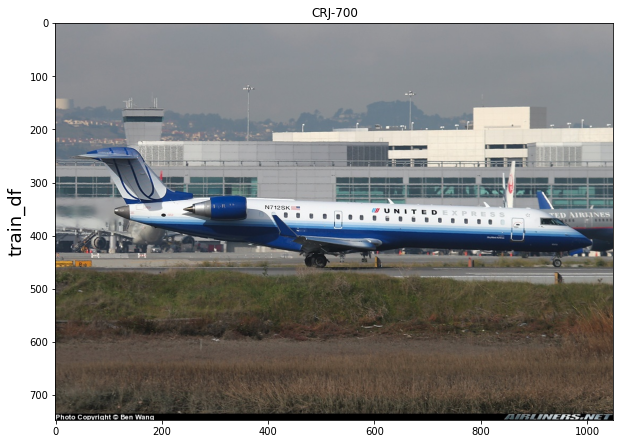

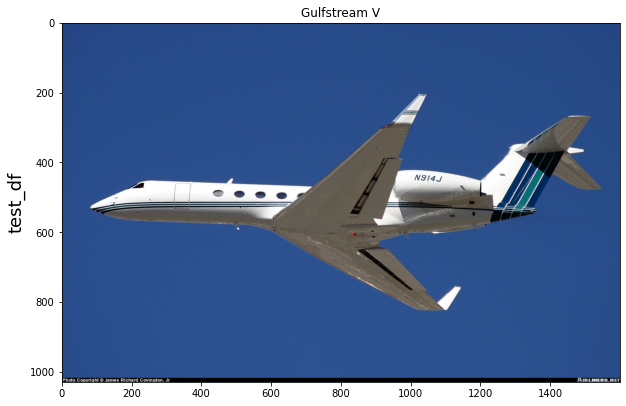

In [14]:
for i in zip(dataframe,name):
    
    plt.figure(figsize=(10,10))
    show_image(train_df, random.randint(0, i[0].shape[0]-1) , target) #randomly image selected for each dataset
    plt.ylabel(i[1], fontsize=18)

### Show the occurences distribution per classes

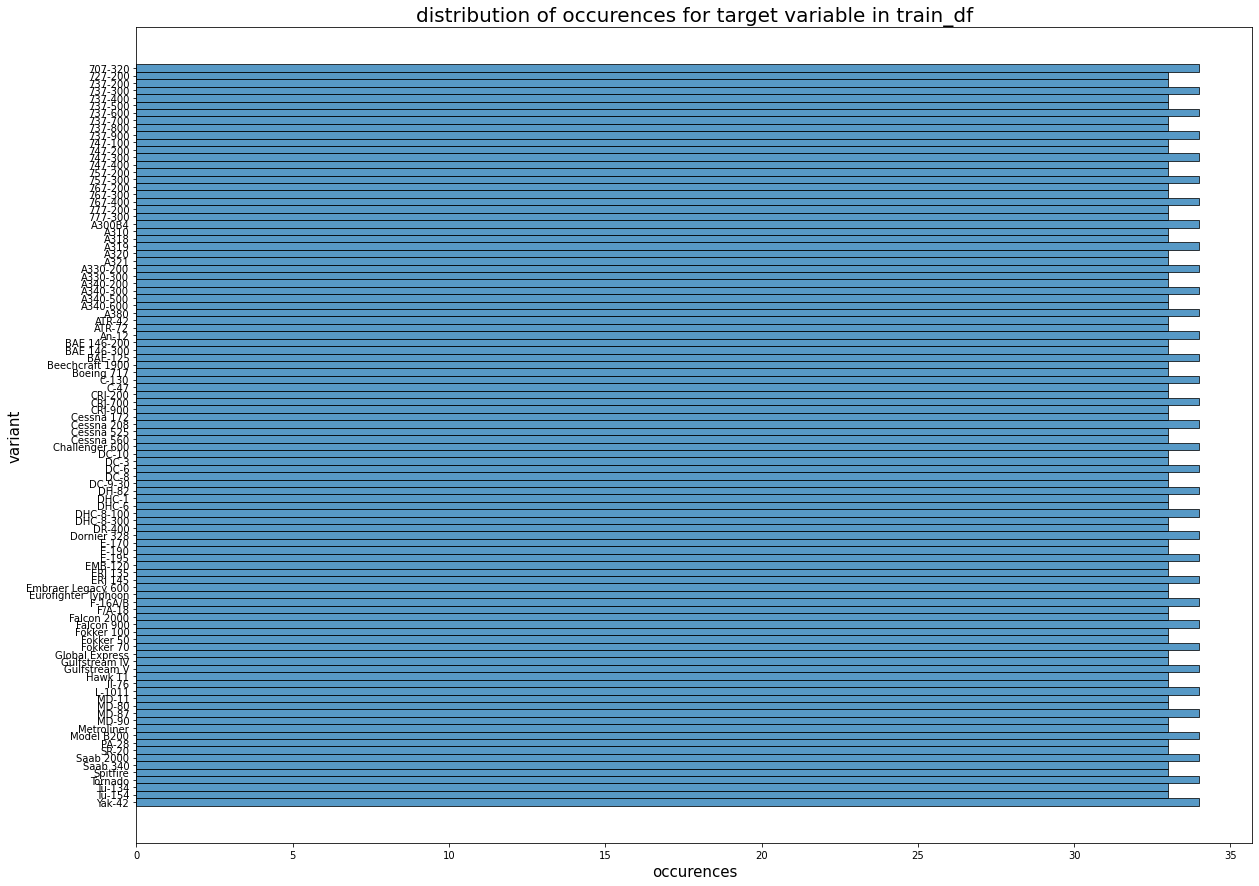

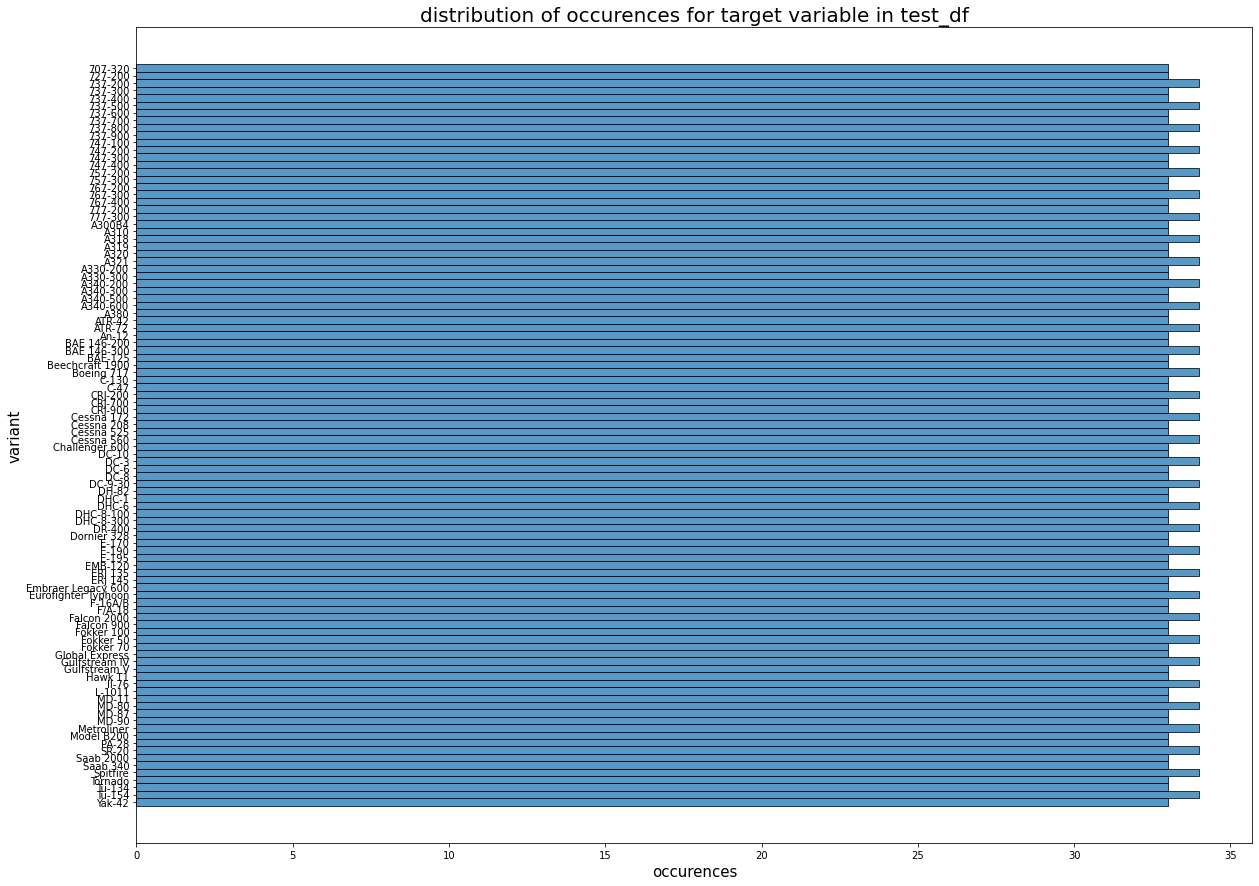

In [15]:
for i in zip(dataframe,name):    
    plt.figure(figsize=(20,15))
    sns.histplot(data=i[0], y=target)
    plt.xlabel("occurences", fontsize=15)
    plt.ylabel(target, fontsize=15)
    plt.title(f"distribution of occurences for target variable in {i[1]}", fontsize=20)
    plt.show()
    print("")
    print("")

## 4) Building the classification model

### define the model

In [17]:
model = build_classiciation_model(train_df, target, 'resized_image')

### define some parameters and train it

In [18]:
epochs, batch_size = 15, 128

history  = model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

2022-04-10 00:14:39.471761: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/15
27/27 [==============================] - 16s 594ms/step - loss: 66.3115 - accuracy: 0.0087 - val_loss: 4.6070 - val_accuracy: 0.0096
Epoch 2/15
27/27 [==============================] - 16s 596ms/step - loss: 4.6054 - accuracy: 0.0087 - val_loss: 4.6585 - val_accuracy: 0.0075
Epoch 3/15
27/27 [==============================] - 16s 583ms/step - loss: 4.6053 - accuracy: 0.0087 - val_loss: 4.6689 - val_accuracy: 0.0075
Epoch 4/15
27/27 [==============================] - 16s 601ms/step - loss: 4.6054 - accuracy: 0.0066 - val_loss: 4.6696 - val_accuracy: 0.0099
Epoch 5/15
27/27 [==============================] - 16s 590ms/step - loss: 4.6054 - accuracy: 0.0078 - val_loss: 4.6697 - val_accuracy: 0.0099
Epoch 6/15
27/27 [==============================] - 17s 623ms/step - loss: 4.6053 - accuracy: 0.0087 - val_loss: 4.6696 - val_accuracy: 0.0093
Epoch 7/15
27/27 [==============================] - 17s 623ms/step - loss: 4.6053 - accuracy: 0.0099 - val_loss: 4.6696 - val_accuracy: 0.008

## 5) Seeing results

### On train set

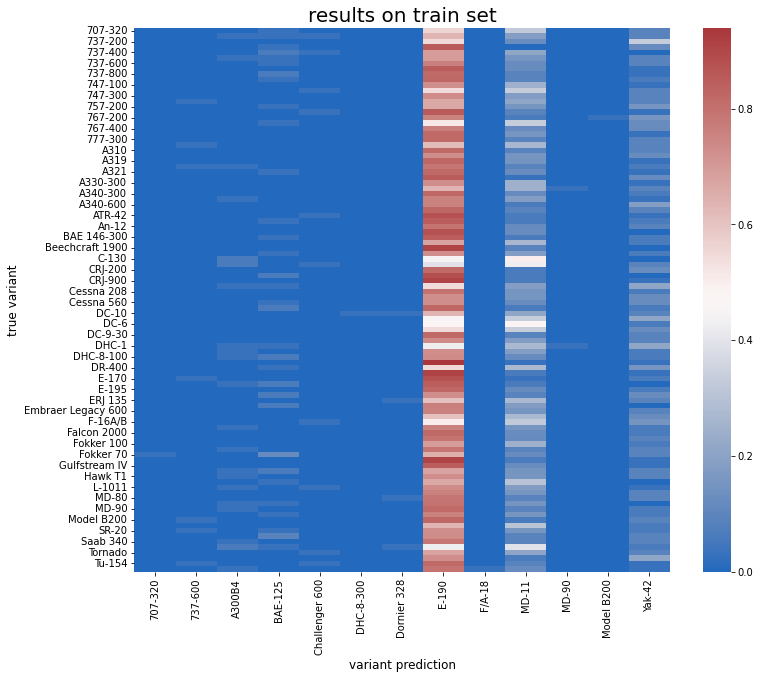

In [19]:
fig,ax  = plt.subplots(figsize=(12,10))

sns.heatmap(pd.crosstab(train_df[target], classify_images(X_train, model, 
                        train_df[target].astype('category').cat.categories), 
                        normalize='index'), cmap='vlag', ax=ax)

plt.xlabel(f"{target} prediction", fontsize=12)
plt.ylabel(f"true {target}",fontsize=12)
plt.title('results on train set',fontsize=20)
plt.show()

### On test set

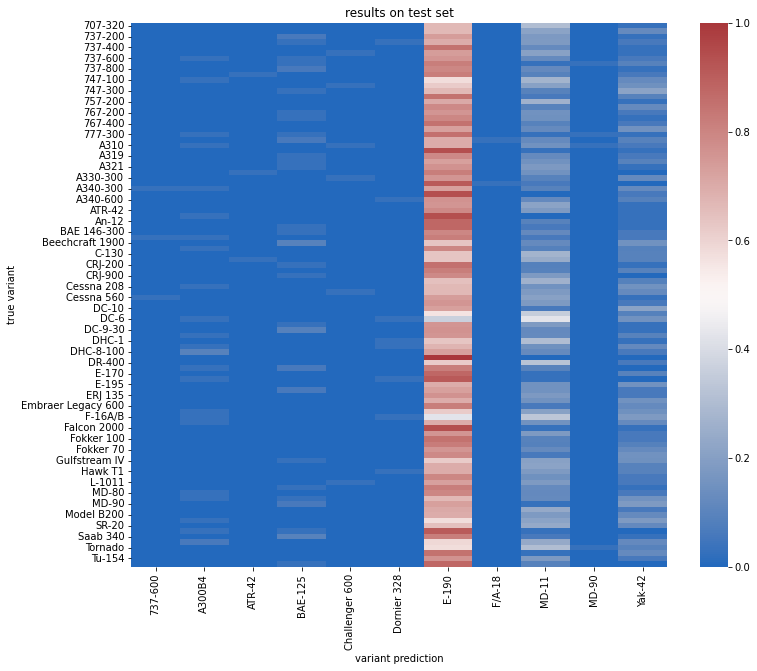

In [20]:
fig,ax  = plt.subplots(figsize=(12,10))

sns.heatmap(pd.crosstab(test_df[target], classify_images(X_test, model, 
                        test_df[target].astype('category').cat.categories), 
                        normalize='index'), cmap='vlag', ax=ax)


plt.xlabel(f"{target} prediction")
plt.ylabel(f"true {target}")
plt.title('results on test set')
plt.show()

## registering the trained model

In [21]:
save_model(model, selector)